In [1]:
import seaborn as sns
import pandas as pd
import scipy.io as sio
import numpy as np
import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from harmony import harmonize
import sys
sys.path.append('../../../ABCA7lof2')
from ABCA7lof2.annotation import run_ipca

# env: suite2p

In [2]:
# load all the data
logcounts_sparse = sio.mmread("../../processed_data/logcounts.mtx")
FEATURES_df = pd.read_csv("../../processed_data/rowData.csv", index_col=0)
meta_indexed = pd.read_csv("../../processed_data/colData.csv", index_col=0)

# assign indices
FEATURES_df.index = FEATURES_df.iloc[:,0]
meta_indexed.index = meta_indexed['barcodes']
FEATURES_df = pd.DataFrame(FEATURES_df.iloc[:,1])
FEATURES_df.columns = ['Gene']

In [3]:
# load the layer marker genes
layer_markers = pd.read_excel('../../processed_data/41593_2017_BFnn4548_MOESM255_ESM.xlsx') # https://www.nature.com/articles/nn.4548#Sec2
markers = layer_markers[['Gene symbol', 'Layer marker in human']].dropna()
markers.columns = ['Gene', 'Layer']
layer_genes = set(markers['Gene'])
gene_indices = [x in layer_genes for x in FEATURES_df.index]


In [4]:
# index the ex neurons
logcounts_sparse_csr = logcounts_sparse.tocsr()
index = (meta_indexed['annotations2']=='Ex').values
logcounts_sparse_csr_ex = logcounts_sparse_csr[index]
meta_indexed_ex = meta_indexed.loc[index]

# index layer genes
FEATURES_df_layer = FEATURES_df.loc[gene_indices]
logcounts_sparse_csr_ex_layer = logcounts_sparse_csr_ex[:,gene_indices]

In [5]:
# remove cells that have low expression of these marker genes
frac_nonzero = np.sum(logcounts_sparse_csr_ex_layer>0, axis=1).reshape(-1)/logcounts_sparse_csr_ex_layer.shape[1]
index2 = np.array(frac_nonzero>0.15)[0]

logcounts_sparse_csr_ex_layer_high = logcounts_sparse_csr_ex_layer[index2]
meta_indexed_ex_high = meta_indexed_ex.loc[index2]


In [6]:
# run iPCA
projection = run_ipca(logcounts_sparse_csr_ex_layer_high.toarray(), 50, 1)

running pca...


In [7]:
# remove batch effects before clustering
meta_indexed_ex_dummies = pd.get_dummies(meta_indexed_ex_high, columns=['projid'], drop_first=True)
L = list(meta_indexed_ex_dummies.columns[[x.split('_')[0]=='projid' for x in meta_indexed_ex_dummies.columns]])
Z = harmonize(projection, meta_indexed_ex_dummies, batch_key = L)

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [8]:
# make the anndata object
adata = sc.AnnData(X=logcounts_sparse_csr_ex_layer_high, obs=meta_indexed_ex_high, var=FEATURES_df_layer)
adata.obsm['X_pca'] = Z
adata.var_names_make_unique(join='.')
adata.obs_names_make_unique(join='.')


In [9]:
# compute neighborhood graph and perform leiden clustering
print('neighborhood graph')
sc.pp.neighbors(adata, use_rep='X_pca', n_pcs=50)
print('leiden clustering')
sc.tl.leiden(adata, resolution=1)
print('UMAP')
sc.tl.umap(adata, min_dist=0.5, spread=1.0, n_components=2, maxiter=None, alpha=1.0, gamma=1.0, negative_sample_rate=5, init_pos='spectral', random_state=0, a=None, b=None, copy=False, method='umap', neighbors_key=None)

neighborhood graph


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/homebrew/Caskroom/miniconda/base/envs/suite2p/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


leiden clustering


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_74857/58178538.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1)


UMAP


In [10]:
# # plot by sequencing batch
# sc.pl.umap(adata[adata.obs['seq_batch']=='JBM'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)
# sc.pl.umap(adata[adata.obs['seq_batch']!='JBM'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)

In [11]:
# sc.pl.umap(adata, color=['leiden'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)

In [12]:
# rank genes by cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

# get scores
scores = adata.uns['rank_genes_groups']['logfoldchanges']
names = adata.uns['rank_genes_groups']['names']
pvals = adata.uns['rank_genes_groups']['pvals_adj']

sele_genes = np.array(pd.DataFrame(names)).T
sele_scores = np.array(pd.DataFrame(scores)).T


celltypes = np.unique(markers['Layer'])
celltype_scores = np.empty(shape=(sele_scores.shape[0], len(celltypes)))

for cluster in range(sele_scores.shape[0]):
    for i in range(len(celltypes)):
        mark = np.array(markers[markers['Layer']==np.unique(celltypes)[i]]['Gene'])    
        dictionary = dict(zip(sele_genes[cluster], sele_scores[cluster]))
        S = np.mean([dictionary[x] for x in mark if x in set(dictionary.keys()) ])
        celltype_scores[cluster][i] = S 
        


/opt/homebrew/Caskroom/miniconda/base/envs/suite2p/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/opt/homebrew/Caskroom/miniconda/base/envs/suite2p/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/opt/homebrew/Caskroom/miniconda/base/envs/suite2p/lib/python3.9/site-packages/sc

In [13]:
# assign layers to clusters
S = pd.DataFrame(celltype_scores)

temp = (S>0.1).T
temp_layer_annotation = [np.argwhere(temp.loc[:,x]) for x in range(temp.shape[1])]
names = []
for i in temp_layer_annotation:
    if len(i) == 0:
        name = 'other'
    elif len(i) == 1:
        name = celltypes[i[0][0]]
    else:
        name = celltypes[i[0][0]] + '/' + celltypes[i[1][0]]
    names.append(name)

cluster_to_layer = dict(zip(np.arange(len(names)).astype(str), names))

adata.obs['layer'] = adata.obs['leiden'].map(cluster_to_layer)

#sc.pl.umap(adata, color=['layer'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)

In [14]:
adata.obs['layer'].value_counts()

layer
L2       10508
L4        8501
L3        7150
L4/L5     4488
L5        3768
other     3027
L6         888
Name: count, dtype: int64

In [15]:
# remove cells that couldnt be annotated 
index3 = [x not in ['other'] for x in adata.obs['layer']]
adata2 = adata[index3]

# combine layer 5 and 6
adata2.obs['layer'] = adata2.obs['layer'].replace('L5', 'L5/6')
adata2.obs['layer'] = adata2.obs['layer'].replace('L6', 'L5/6')

# run UMAP
sc.tl.umap(adata2, min_dist=0.5, spread=1.0, n_components=2, maxiter=None, alpha=1.0, gamma=1.0, negative_sample_rate=5, init_pos='spectral', random_state=0, a=None, b=None, copy=False, method='umap', neighbors_key=None)

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_74857/4166568985.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata2.obs['layer'] = adata2.obs['layer'].replace('L5', 'L5/6')


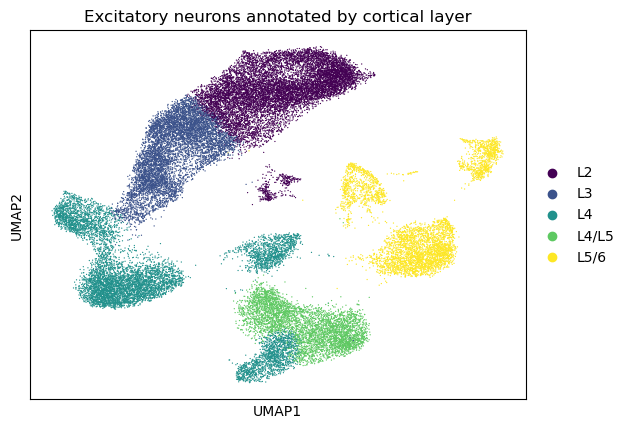

In [106]:
# plot neurons by layer
sc.pl.umap(adata2, color=['layer'], frameon=True, gene_symbols='Gene', palette='viridis', title='Excitatory neurons annotated by cortical layer', return_fig=True)
plt.savefig('../../paper/extended_plots/ex_neuronal_subtypes.png', bbox_inches='tight')

In [103]:
# show enrichment scores 

# rank genes by cluster
sc.tl.rank_genes_groups(adata2, 'layer', method='t-test')

# get scores
scores = adata2.uns['rank_genes_groups']['logfoldchanges']
names = adata2.uns['rank_genes_groups']['names']
pvals = adata2.uns['rank_genes_groups']['pvals_adj']

sele_genes = np.array(pd.DataFrame(names)).T
sele_scores = np.array(pd.DataFrame(scores)).T


celltypes = np.unique(markers['Layer'])
celltype_scores = np.empty(shape=(sele_scores.shape[0], len(celltypes)))

for cluster in range(sele_scores.shape[0]):
    for i in range(len(celltypes)):
        mark = np.array(markers[markers['Layer']==np.unique(celltypes)[i]]['Gene'])    
        dictionary = dict(zip(sele_genes[cluster], sele_scores[cluster]))
        S = np.mean([dictionary[x] for x in mark if x in set(dictionary.keys()) ])
        celltype_scores[cluster][i] = S 
        
celltype_scores = pd.DataFrame(celltype_scores)
celltype_scores.index = np.unique(adata2.obs['layer'])
celltype_scores.columns = celltypes

<Figure size 200x500 with 0 Axes>

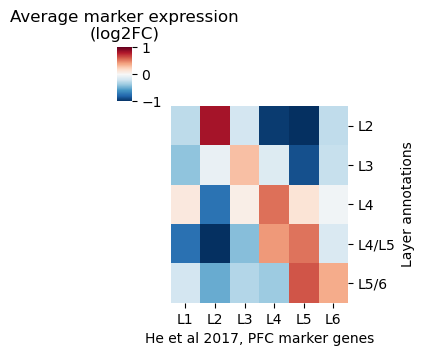

In [104]:
plt.figure(figsize=(2, 5))
g = sns.clustermap(celltype_scores, cmap='RdBu_r', vmin=-1, vmax=1, col_cluster=False, row_cluster=False, figsize=(3, 3)
                   )
g.ax_heatmap.set_xlabel('He et al 2017, PFC marker genes')
g.ax_heatmap.set_ylabel('Layer annotations')
g.cax.set_title('Average marker expression\n(log2FC)')

# Move the legend to the right side of the heatmap
plt.savefig('../../paper/extended_plots/ex_neuronal_subtypes_he_markers.png', bbox_inches='tight')





In [93]:
# look at one additional set of markers, then save the annotations

markers2 = pd.read_excel('../../processed_data/41593_2020_787_MOESM3_ESM.xlsx', sheet_name='Table S4B') # from https://www.nature.com/articles/s41593-020-00787-0#Abs1
out = []
for i in ['Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6']:
    temp = (markers2['gene'][(markers2['fdr_'+i]<0.05) & (markers2['t_stat_'+i]>0)]).values
    temp_df = pd.DataFrame(temp)
    temp_df['Layer'] = i
    temp_df.columns = ['Gene', 'Layer']
    out.append(temp_df)

markers2_subset = pd.concat(out)


In [94]:
celltypes = np.unique(markers2_subset['Layer'])
celltype_scores = np.empty(shape=(sele_scores.shape[0], len(celltypes)))

for cluster in range(sele_scores.shape[0]):
    for i in range(len(celltypes)):
        mark = np.array(markers2_subset[markers2_subset['Layer']==np.unique(celltypes)[i]]['Gene'])    
        dictionary = dict(zip(sele_genes[cluster], sele_scores[cluster]))
        S = np.mean([dictionary[x] for x in mark if x in set(dictionary.keys()) ])
        celltype_scores[cluster][i] = S 
    

In [95]:
celltype_scores = pd.DataFrame(celltype_scores)
celltype_scores.index = np.unique(adata2.obs['layer'])
celltype_scores.columns = celltypes

<Figure size 200x500 with 0 Axes>

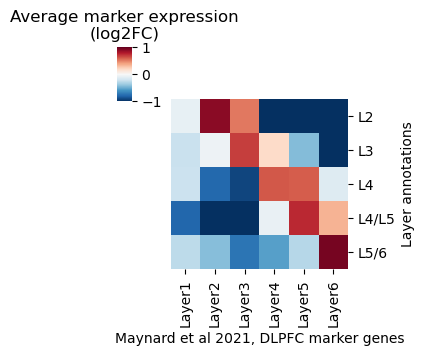

In [102]:
plt.figure(figsize=(2, 5))
g = sns.clustermap(celltype_scores, cmap='RdBu_r', vmin=-1, vmax=1, col_cluster=False, row_cluster=False, figsize=(3, 3)
                   )
g.ax_heatmap.set_xlabel('Maynard et al 2021, DLPFC marker genes')
g.ax_heatmap.set_ylabel('Layer annotations')
g.cax.set_title('Average marker expression\n(log2FC)')

# Move the legend to the right side of the heatmap
plt.savefig('../../paper/extended_plots/ex_neuronal_subtypes_maynard_markers.png', bbox_inches='tight')



In [99]:
adata2.obs['layer'].to_csv('../../processed_data/Ex_layer_annotations.csv')

## below is scrap

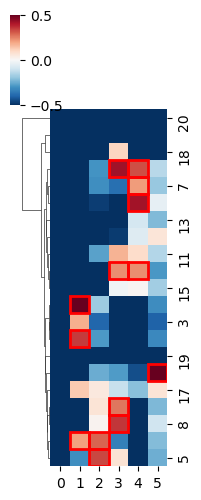

In [211]:
g = sns.clustermap(S, cmap='RdBu_r', vmin=-0.5, vmax=0.5, col_cluster=False, figsize=(2, 5))

# Get the reordered indices for rows (and columns, if applicable)
row_order = g.dendrogram_row.reordered_ind
# For columns, if not clustering, the order is the original order:
col_order = range(S.shape[1])

# Loop through each cell in the reordered data and add a rectangle if the value > 0.25
for i, row in enumerate(row_order):
    for j, col in enumerate(col_order):
        if S.iloc[row, col] > 0.2:
            # (j, i) is the coordinate of the cell in the heatmap.
            rect = patches.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=2)
            g.ax_heatmap.add_patch(rect)


In [155]:
assignments = np.array([celltypes[np.argmax(x)] for x in celltype_scores])
dictionary = dict(zip(np.arange(len(assignments)), assignments))
adata.obs['Assignment'] = [dictionary[int(x)] for x in np.array(adata.obs['leiden'])]

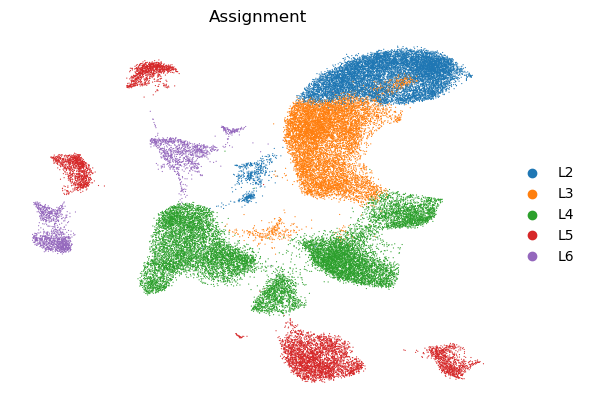

In [156]:
sc.pl.umap(adata, color=['Assignment'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)

In [157]:
adata.obs['Assignment'].value_counts()

Assignment
L4    13897
L2    10436
L3     9574
L5     5920
L6     2187
Name: count, dtype: int64

<Axes: xlabel='x', ylabel='y'>

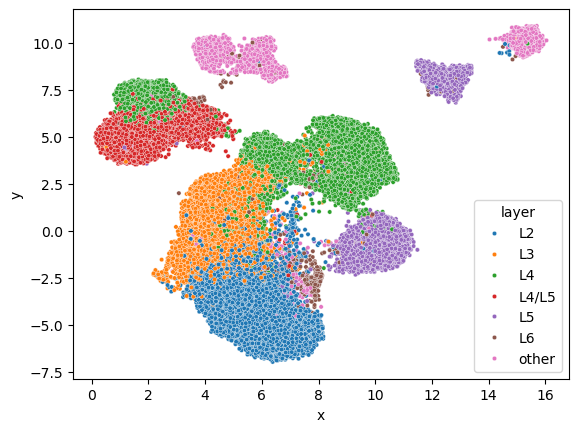

In [162]:
np.max(celltype_scores, axis=1)

array([ 0.29121846,  0.2675142 ,  0.42247555,  0.18277383,  0.60912168,
        0.33316341,  0.34791872,  0.21167503,  0.35928637,  0.23362385,
       -0.58691508,  0.17265457,  0.0641554 , -0.08713553,  0.81407034,
        0.01142604,  0.42059055,  0.13215126,  0.10588805, -0.4992376 ,
       -1.98191094])

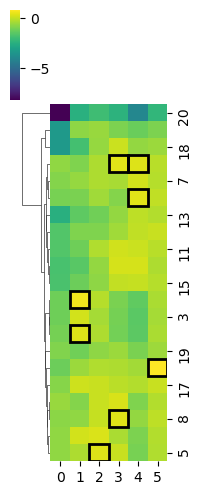

In [90]:
np.log2(1.25)

0.32192809488736235

In [5]:
# index larger clusters
cluster_sizes = meta_indexed_ex['leiden_clusters'].value_counts()
keep_clusters = set(np.array(cluster_sizes[cluster_sizes > 1000].index))

keep_clusters_index = [x in keep_clusters for x in meta_indexed_ex['leiden_clusters']]
meta_indexed_ex_keep = meta_indexed_ex[keep_clusters_index]
logcounts_sparse_csr_ex_layer_keep = logcounts_sparse_csr_ex_layer[keep_clusters_index]

In [6]:
meta_indexed_ex_keep['leiden_clusters'] = meta_indexed_ex_keep['leiden_clusters'].astype(str)
x = np.unique(meta_indexed_ex_keep['leiden_clusters'])
dictionary = dict(zip(x,np.arange(len(x))))
meta_indexed_ex_keep['leiden'] = meta_indexed_ex_keep['leiden_clusters'].map(dictionary)
meta_indexed_ex_keep['leiden'] = meta_indexed_ex_keep['leiden'].astype('category')

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67169/3368208300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_indexed_ex_keep['leiden_clusters'] = meta_indexed_ex_keep['leiden_clusters'].astype(str)
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67169/3368208300.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_indexed_ex_keep['leiden'] = meta_indexed_ex_keep['leiden_clusters'].map(dictionary)
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67169/33682083

In [7]:
cluster_sizes_crosstab = pd.crosstab(meta_indexed_ex_keep['leiden'], meta_indexed_ex_keep['seq_batch'])
cluster_sizes_crosstab_percentage = cluster_sizes_crosstab.div(cluster_sizes_crosstab.sum(axis=0), axis=1) * 100
cluster_sizes_crosstab_percentage

seq_batch,171013Tsa,JBM
leiden,,
0,24.897867,24.499816
1,8.079891,8.090927
2,9.940990,7.353066
3,6.014526,5.431790
4,4.380390,4.832988
5,3.018611,2.923064
6,18.361325,17.822176
7,13.481616,17.021880
8,11.824784,12.024293


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [12]:
scores = adata.uns['rank_genes_groups']['logfoldchanges']
names = adata.uns['rank_genes_groups']['names']
pvals = adata.uns['rank_genes_groups']['pvals_adj']

sele_genes = np.array(pd.DataFrame(names)).T
sele_scores = np.array(pd.DataFrame(scores)).T


In [13]:

celltypes = np.unique(markers['Layer'])
celltype_scores = np.empty(shape=(sele_scores.shape[0], len(celltypes)))

for cluster in range(sele_scores.shape[0]):
    for i in range(len(celltypes)):
        mark = np.array(markers[markers['Layer']==np.unique(celltypes)[i]]['Gene'])    
        dictionary = dict(zip(sele_genes[cluster], sele_scores[cluster]))
        S = np.mean([dictionary[x] for x in mark if x in set(dictionary.keys()) ])
        celltype_scores[cluster][i] = S 
        

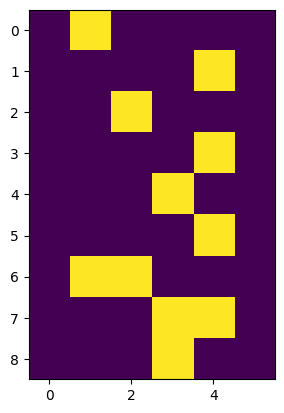

In [25]:
S = pd.DataFrame(celltype_scores)
plt.imshow(S>0.2)

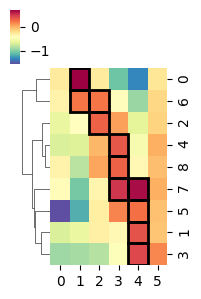

In [27]:

# Create the clustermap
g = sns.clustermap(S, cmap='Spectral_r', col_cluster=False, figsize=(2, 3))

# Get the reordered indices for rows (and columns, if applicable)
row_order = g.dendrogram_row.reordered_ind
# For columns, if not clustering, the order is the original order:
col_order = range(S.shape[1])

# Loop through each cell in the reordered data and add a rectangle if the value > 0.25
for i, row in enumerate(row_order):
    for j, col in enumerate(col_order):
        if S.iloc[row, col] > 0.2:
            # (j, i) is the coordinate of the cell in the heatmap.
            rect = patches.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=2)
            g.ax_heatmap.add_patch(rect)

plt.show()


<Axes: xlabel='x', ylabel='y'>

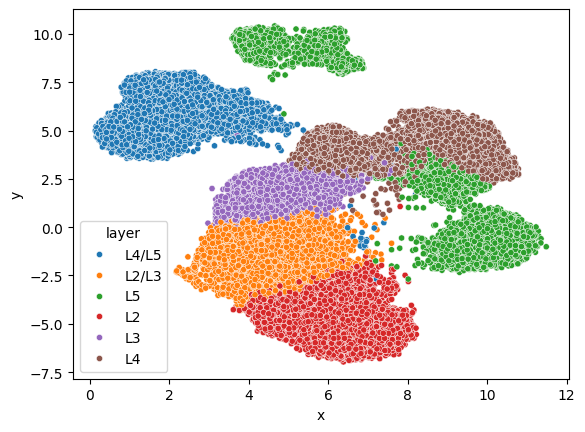

In [37]:
temp = pd.crosstab(adata.obs['layer'], adata.obs['projid'])

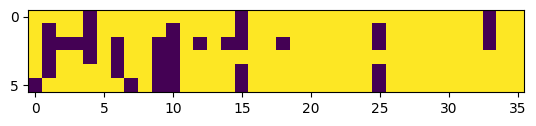

In [44]:
plt.imshow(temp>50)

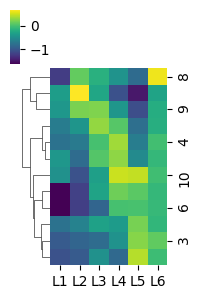

In [148]:
S.columns = celltypes

sns.clustermap(S, cmap='viridis', col_cluster=False, figsize=(2, 3))


In [186]:
np.log2(1.2)

0.2630344058337938

In [83]:
S['cluster'] = S.index

/opt/homebrew/Caskroom/miniconda/base/envs/suite2p/lib/python3.9/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1000x1000 with 0 Axes>

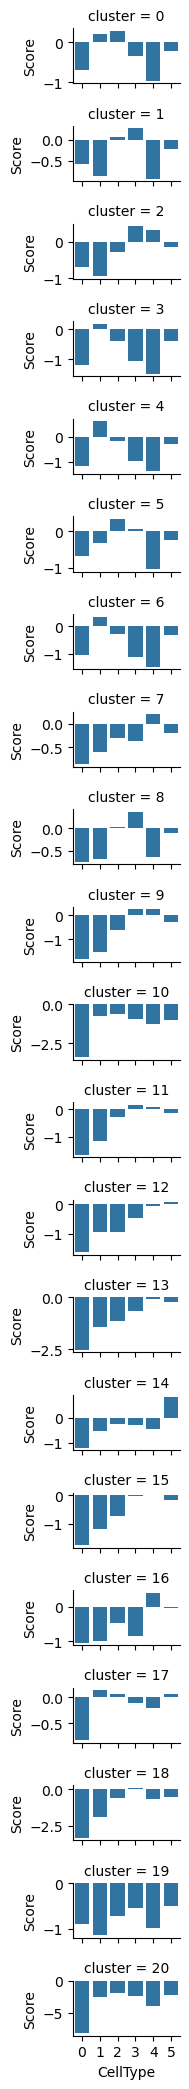

In [84]:
plt.figure(figsize=(10, 10))

S_melted = S.melt(id_vars='cluster', var_name='CellType', value_name='Score')
g = sns.FacetGrid(S_melted, col='cluster', col_wrap=1, sharex=True, sharey=False, height=1, aspect=2
                  
                  )
g.map(sns.barplot, 'CellType', 'Score')


In [118]:
assignments = np.array([celltypes[np.argmax(x)] for x in celltype_scores])
dictionary = dict(zip(np.arange(len(assignments)), assignments))

In [120]:

adata.obs['Assignment'] = [dictionary[int(x)] for x in np.array(adata.obs['leiden'])]

<Axes: xlabel='x', ylabel='y'>

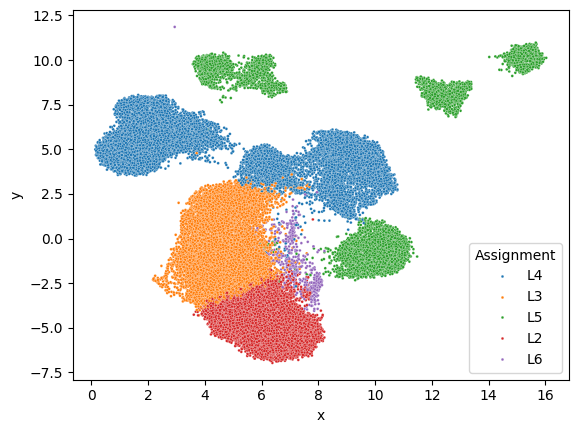

In [199]:
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['Assignment'], s=4)

<Axes: xlabel='x', ylabel='y'>

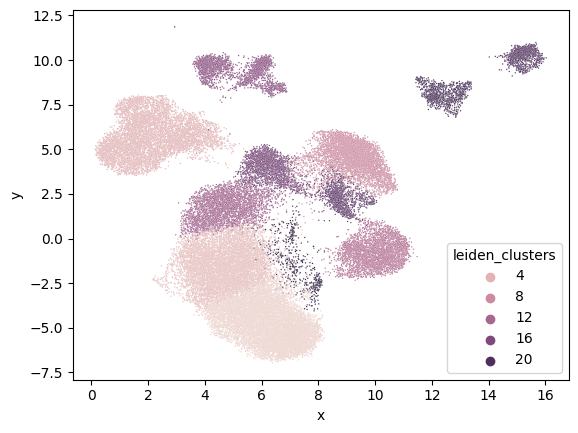

In [6]:
sns.scatterplot(data=df[df['annotations2'] == 'Ex'], x='x', y='y', hue='leiden_clusters', s=1)

In [3]:
scores = adata.uns['rank_genes_groups']['logfoldchanges']
names = adata.uns['rank_genes_groups']['names']
pvals = adata.uns['rank_genes_groups']['pvals_adj']

In [ ]:
# assign marker scores to infer celltypes
markers = pd.read_csv('./processed_data/single_cell/brain_marker_genes.csv')

scores = adata.uns['rank_genes_groups']['logfoldchanges']
names = adata.uns['rank_genes_groups']['names']
pvals = adata.uns['rank_genes_groups']['pvals_adj']

sele_genes = np.array(pd.DataFrame(names)).T
sele_scores = np.array(pd.DataFrame(scores)).T

celltypes = np.unique(markers['major_celltype'])
celltype_scores = np.empty(shape=(sele_scores.shape[0], len(celltypes)))

for cluster in range(sele_scores.shape[0]):
    for i in range(len(celltypes)):
        mark = np.array(markers[markers['major_celltype']==np.unique(celltypes)[i]]['marker'])    
        dictionary = dict(zip(sele_genes[cluster], sele_scores[cluster]))
        S = np.mean([dictionary[x] for x in mark if x in set(dictionary.keys()) ])
        celltype_scores[cluster][i] = S 
        
assignments = np.array([celltypes[np.argmax(x)] for x in celltype_scores])
dictionary = dict(zip(np.arange(len(assignments)), assignments))
adata.obs['Assignment'] = [dictionary[int(x)] for x in np.array(adata.obs['leiden'])]